In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class ArgoverseForecastingLoader:
    def __init__(self, root_dir: str):
        """Initialization function for the class.

        Args:
            root_dir: Path to the folder having sequence csv files
        """
        self.path_sequence = [os.path.join(root_dir, x) for x in os.listdir(root_dir)]
        self.len = len(self.path_sequence)

    def __len__(self) -> int:
        """Get the number of sequences in the data

        Returns:
            Number of sequences in the data
        """
        return self.len

    def get_df(self, csv_id: int) -> pd.DataFrame:
        """Get the dataframe for the specific sequence.

        Returns:
            pandas DataFrame for the specific sequence
        """
        return pd.read_csv(self.path_sequence[csv_id]).dropna()

In [2]:
##set root_dir to the correct path to your dataset folder
root_dir = 'data'

afl = ArgoverseForecastingLoader(root_dir)
print('Total number of sequences:',len(afl))

for i in range(len(afl)):
    df =  afl.get_df(i)
    if df[df['OBJECT_TYPE'] == 'AGENT'].shape[0] != 50:
        print(afl.path_sequence[i])


Total number of sequences: 3900


In [3]:
def get_agent_traj(df: pd.DataFrame) -> list:
    agent_x = df[df["OBJECT_TYPE"] == "AGENT"]["X"]
    agent_y = df[df["OBJECT_TYPE"] == "AGENT"]["Y"]
    
    return np.column_stack((agent_x, agent_y))

In [4]:
def draw_trajectory(traj: np.ndarray):
    # draw multiple trajectories
    ax = plt.gca()

    plt.plot(traj[0,0,0],traj[0,0,1],'-o',c='r') #starting point here
    plt.plot(traj[0,:21,0],traj[0,:21,1],'-',c='b')

    for i in range(len(traj)):
        plt.plot(traj[i,20:,0],traj[i,20:,1],'-',c=np.random.rand(3,))
    plt.xlabel('map_x_coord (m)')
    plt.ylabel('map_y_coord (m)')
    ax.set_aspect('equal')
    plt.show()

In [5]:
def get_ade(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """
    Returns:
        ade: Average Displacement Error
    """
    pred_len = forecasted_trajectory.shape[0]
    ade = float(
        sum(
            math.sqrt(
                (forecasted_trajectory[i, 0] - gt_trajectory[i, 0]) ** 2
                + (forecasted_trajectory[i, 1] - gt_trajectory[i, 1]) ** 2
            )
            for i in range(pred_len)
        )
        / pred_len
    )
    return ade

In [6]:
def get_fde(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """
    Returns:
        fde: Final Displacement Error
    """
    fde = float(
                (forecasted_trajectory[-1, 0] - gt_trajectory[-1, 0]) ** 2
                + (forecasted_trajectory[-1, 1] - gt_trajectory[-1, 1]) ** 2
            )
    return fde

In [7]:
def evaluation(afl, prediction, fast_run=False):
    total = len(afl) if not fast_run else int(len(afl) / 20)
    minADE = 0
    minFDE = 0
    for i in range(total):
        print('\r'+str(i + 1)+'/'+str(total),end="")
        df = afl.get_df(i)
        gt_traj = get_agent_traj(df)
        predict_traj_list = prediction(df)
        minADE += min([get_ade(gt_traj, predict_traj) for predict_traj in predict_traj_list])
        minFDE += min([get_fde(gt_traj, predict_traj) for predict_traj in predict_traj_list])
    minADE /= total
    minFDE /= total
    return {
        "minADE": minADE,
        "minFDE": minFDE
    }

data\1007.csv


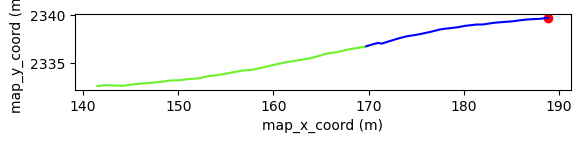

,TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,CITY_NAME
0,3.159677e+08,00000000-0000-0000-0000-000000000000,AV,214.353889,2341.451892,MIA
1,3.159677e+08,00000000-0000-0000-0000-000000020136,OTHERS,241.113872,2342.864331,MIA
2,3.159677e+08,00000000-0000-0000-0000-000000020720,OTHERS,243.831954,2312.855606,MIA
3,3.159677e+08,00000000-0000-0000-0000-000000020721,OTHERS,242.697031,2306.406028,MIA
4,3.159677e+08,00000000-0000-0000-0000-000000019966,AGENT,188.883156,2339.719714,MIA


In [8]:
print(afl.path_sequence[10])
df_demo = afl.get_df(10)
draw_trajectory(np.array([get_agent_traj(df_demo)]))

df_demo.head()

In [9]:
def prediction_baseline(df: pd.DataFrame, past_points=20, pred_points=30):
    # a simple prediction function that predict straight line depend on the nearest velocity

    df = df[df["OBJECT_TYPE"] == "AGENT"][["X", "Y"]]
    trajectory = df.iloc[:past_points].to_numpy()

    velocity_x = trajectory[-1, 0] - trajectory[-2, 0]
    velocity_y = trajectory[-1, 1] - trajectory[-2, 1]

    result = np.zeros((past_points + pred_points, 2))
    result[:past_points] = trajectory
    
    for i in range(pred_points):
        result[past_points + i] = result[past_points + i - 1] + np.array([velocity_x, velocity_y])
    
    return np.array([result])

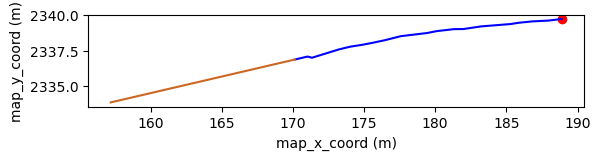

195/195{'minADE': 2.7057276078063057, 'minFDE': 158.48967563291072}


In [10]:
predict_traj = prediction_baseline(df_demo)
draw_trajectory(predict_traj)

print(evaluation(afl, prediction_baseline, fast_run=True))

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

regressor = LinearRegression
# regressor = SVR

def prediction_regression(df: pd.DataFrame, past_points=20, pred_points=30, calc_points=20, regressor=regressor):
    # a prediction function that predict by linear/random forest regression

    df = df[df["OBJECT_TYPE"] == "AGENT"][["X", "Y"]]
    trajectory = df.iloc[:past_points].to_numpy()

    time_steps = np.arange(past_points - calc_points, past_points).reshape(-1, 1)
    model_x = regressor().fit(time_steps, trajectory[-calc_points:, 0])
    model_y = regressor().fit(time_steps, trajectory[-calc_points:, 1])

    pred_time_steps = np.arange(past_points, past_points + pred_points).reshape(-1, 1)
    pred_x = model_x.predict(pred_time_steps)
    pred_y = model_y.predict(pred_time_steps)

    pred_trajectory = np.column_stack((pred_x, pred_y))
    result = np.vstack((trajectory, pred_trajectory))

    return np.array([result])

In [12]:
from functools import partial

result = []
for i in range(2, 21):
    print(f"\r            calc_points = {i}", end="")
    eval_result = evaluation(afl, partial(prediction_regression, calc_points=i), fast_run=True)
    result.append({
        "calc_points": i,
        "minADE": eval_result['minADE'],
        "minFDE": eval_result['minFDE']
    })
result_df = pd.DataFrame(result)

195/195     calc_points = 20

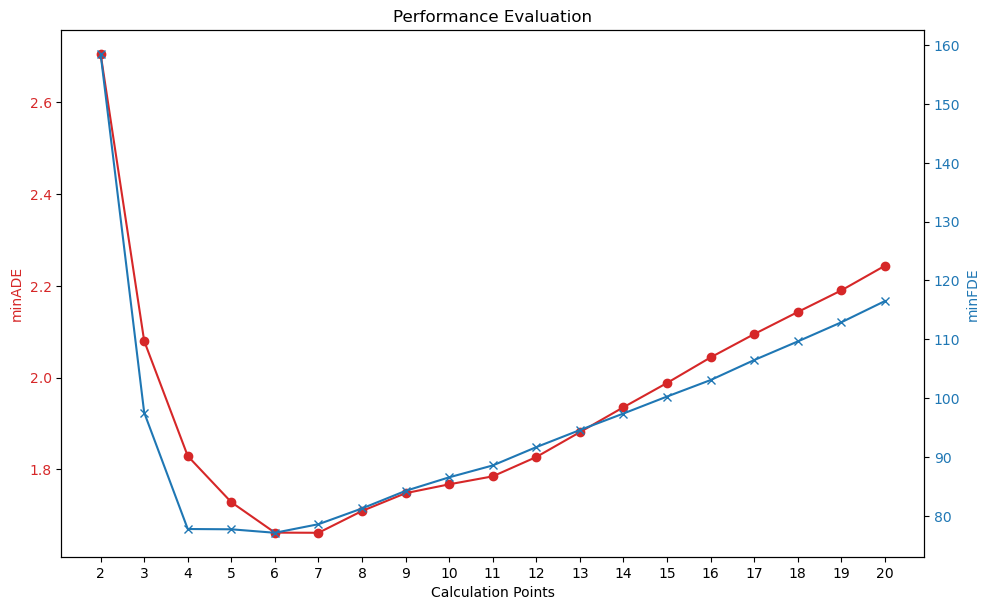

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Calculation Points')
ax1.set_ylabel('minADE', color=color)
ax1.plot(result_df['calc_points'], result_df['minADE'], label='minADE', marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.set_xticks(range(2, 21))

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('minFDE', color=color)
ax2.plot(result_df['calc_points'], result_df['minFDE'], label='minFDE', marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Performance Evaluation')
plt.show()

[[[ 188.88315619 2339.71971383]
  [ 187.95963132 2339.60693045]
  [ 186.81595585 2339.55009128]
  [ 185.85324046 2339.4517481 ]
  [ 185.29690735 2339.36391357]
  [ 183.2272483  2339.1984623 ]
  [ 181.98263    2339.01288261]
  [ 181.31138163 2339.00633291]
  [ 180.08464694 2338.86331843]
  [ 179.43819495 2338.7341853 ]
  [ 179.43819495 2338.7341853 ]
  [ 177.5876286  2338.51261854]
  [ 176.43385744 2338.22180351]
  [ 175.51853558 2338.02889796]
  [ 174.83373669 2337.89873143]
  [ 174.03585337 2337.77571279]
  [ 173.24127799 2337.58306234]
  [ 171.33682234 2336.99577617]
  [ 171.03461292 2337.0800641 ]
  [ 170.58827044 2336.97610861]
  [ 169.35729076 2336.68038772]
  [ 168.46128812 2336.48125774]
  [ 167.56528547 2336.28212777]
  [ 166.66928283 2336.08299779]
  [ 165.77328019 2335.88386781]
  [ 164.87727755 2335.68473784]
  [ 163.9812749  2335.48560786]
  [ 163.08527226 2335.28647788]
  [ 162.18926962 2335.0873479 ]
  [ 161.29326697 2334.88821793]
  [ 160.39726433 2334.68908795]
  [ 159.

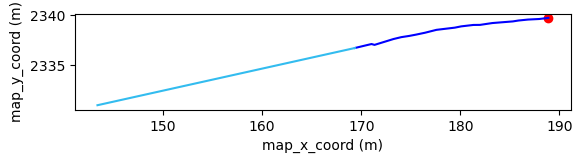

In [14]:
predict_traj = prediction_regression(df_demo, calc_points=7)
print(predict_traj)
draw_trajectory(predict_traj)

In [15]:
# regressor = LinearRegression
# regressor = RandomForestRegressor
regressor = SVR

def get_nearest_obstacle(df):
    # 初始化NEAREST_OBSTACLE列
    df['NEAREST_OBSTACLE'] = np.inf
    
    for index, row in df.iterrows():
        # 提取当前轨迹点的预测位置
        df_tmp = df[df['TIMESTAMP'] == row['TIMESTAMP']]
        current_predicted_x = row['X']
        current_predicted_y = row['Y']
        
        # 计算与其他轨迹点的L2距离
        distances = np.sqrt((df_tmp['X'] - current_predicted_x)**2 + (df_tmp['Y'] - current_predicted_y)**2)
        
        # 排除当前轨迹点自身
        distances[index] = np.inf
        
        # 更新NEAREST_OBSTACLE值
        df.at[index, 'NEAREST_OBSTACLE'] = distances.min()
        if np.isinf(df.at[index, 'NEAREST_OBSTACLE']):
            df.at[index, 'NEAREST_OBSTACLE'] = 0
    
    return df

def get_feature(init_df: pd.DataFrame, len=50) -> pd.DataFrame:
    df = init_df.copy()
    df = df[df['OBJECT_TYPE']=='AGENT']
    df = df.head(len)

    df['VELOCITY_X'] = df.groupby('TRACK_ID')['X'].diff().fillna(0)
    df['VELOCITY_Y'] = df.groupby('TRACK_ID')['Y'].diff().fillna(0)

    df['MEAN_VELOCITY_X'] = df.groupby('TRACK_ID')['VELOCITY_X'].transform(lambda x: x.iloc[1:].mean())
    df['MEAN_VELOCITY_Y'] = df.groupby('TRACK_ID')['VELOCITY_Y'].transform(lambda x: x.iloc[1:].mean())

    df['ACCELERATION_X'] = df.groupby('TRACK_ID')['VELOCITY_X'].diff().fillna(0)
    df['ACCELERATION_Y'] = df.groupby('TRACK_ID')['VELOCITY_Y'].diff().fillna(0)

    df['MEAN_ACCELERATION_X'] = df.groupby('TRACK_ID')['ACCELERATION_X'].transform(lambda x: x.iloc[2:].mean())
    df['MEAN_ACCELERATION_Y'] = df.groupby('TRACK_ID')['ACCELERATION_Y'].transform(lambda x: x.iloc[2:].mean())

    df['ANGULAR_MOMENTUM'] = df['VELOCITY_X'] * df['ACCELERATION_Y'] - df['VELOCITY_Y'] * df['ACCELERATION_X']
    df['MEAN_ANGULAR_MOMENTUM'] = df.groupby('TRACK_ID')['ANGULAR_MOMENTUM'].transform(lambda x: x.iloc[2:].mean())
    
    df['NEAREST_OBSTACLE'] = init_df['NEAREST_OBSTACLE']
    df = get_nearest_obstacle(df)

    return df

# get_feature(df_demo).head()

In [16]:
M = 7
feature_used = ['VELOCITY_X', 'VELOCITY_Y', 'MEAN_VELOCITY_X', 'MEAN_VELOCITY_Y', 'ACCELERATION_X', 'ACCELERATION_Y','MEAN_ACCELERATION_X','MEAN_ACCELERATION_Y','ANGULAR_MOMENTUM','MEAN_ANGULAR_MOMENTUM', 'NEAREST_OBSTACLE']

def train_model(afl, M):
    features_list = []
    targets_list = []
    
    for i in range(int(len(afl) / 20), 11 * int(len(afl) / 20)):
        df = afl.get_df(i)
        df = get_nearest_obstacle(df)
        df = get_feature(df)
        
        if len(df) - M - 2 <= 0:
            continue
        
        for start_idx in range(2, len(df) - M):
            end_idx = start_idx + M
            features = df.iloc[start_idx:end_idx][feature_used].to_numpy().flatten()
            target = df.iloc[end_idx][['VELOCITY_X', 'VELOCITY_Y']].to_numpy()
            features_list.append(features)
            targets_list.append(target)
    
    # 将列表转换为NumPy数组
    features_array = np.array(features_list)
    targets_array = np.array(targets_list)
    
    # 训练模型
    model_x = regressor().fit(features_array, targets_array[:, 0])
    model_y = regressor().fit(features_array, targets_array[:, 1])
    
    return model_x, model_y

model_x, model_y = train_model(afl, M)

In [ ]:
def prediction_regression_2(init_df: pd.DataFrame, past_points=20, pred_points=30):
    # 确保df已经包含了起始的特征
    init_df = init_df.copy()
    init_df = get_nearest_obstacle(init_df)
    df = get_feature(init_df, past_points)

    # 使用最后M个时间点的特征作为初始特征
    for i in range(pred_points):
        # 获取最后一个时间点的特征
        last_features = df.iloc[-M:][feature_used].to_numpy().flatten().reshape(1, -1)
        
        # 预测下一个时间点的速度
        next_velocity_x = model_x.predict(last_features)
        next_velocity_y = model_y.predict(last_features)
    
        next_position_x = df.iloc[-1]['X'] + next_velocity_x
        next_position_y = df.iloc[-1]['Y'] + next_velocity_y
        
        new_row = pd.DataFrame({'X': next_position_x, 'Y': next_position_y, 'TRACK_ID': df.iloc[0]['TRACK_ID'], 'OBJECT_TYPE': 'AGENT'})
        df = pd.concat([df, new_row], ignore_index=True)
        df = get_feature(df, past_points + i + 1)

    # 将预测的位置转换为NumPy数组并返回
    return np.array([df[['X','Y']].to_numpy()])

[[[ 188.88315619 2339.71971383]
  [ 187.95963132 2339.60693045]
  [ 186.81595585 2339.55009128]
  [ 185.85324046 2339.4517481 ]
  [ 185.29690735 2339.36391357]
  [ 183.2272483  2339.1984623 ]
  [ 181.98263    2339.01288261]
  [ 181.31138163 2339.00633291]
  [ 180.08464694 2338.86331843]
  [ 179.43819495 2338.7341853 ]
  [ 179.43819495 2338.7341853 ]
  [ 177.5876286  2338.51261854]
  [ 176.43385744 2338.22180351]
  [ 175.51853558 2338.02889796]
  [ 174.83373669 2337.89873143]
  [ 174.03585337 2337.77571279]
  [ 173.24127799 2337.58306234]
  [ 171.33682234 2336.99577617]
  [ 171.03461292 2337.0800641 ]
  [ 170.58827044 2336.97610861]
  [ 169.54266403 2336.69252927]
  [ 168.76147843 2336.45760845]
  [ 167.99876987 2336.28076257]
  [ 167.22573021 2336.1087858 ]
  [ 166.37911045 2335.90116971]
  [ 165.48069321 2335.68992299]
  [ 164.72020857 2335.49620153]
  [ 163.89747214 2335.28818377]
  [ 163.06891191 2335.08546307]
  [ 162.25756943 2334.88499135]
  [ 161.4376486  2334.67805345]
  [ 160.

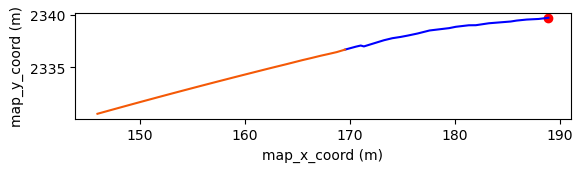

data\1035.csv
[[[2955.95925947 1417.40721829]
  [2955.95925947 1417.40721829]
  [2955.98491994 1417.39774708]
  [2956.04493958 1417.43258816]
  [2956.03707821 1417.42507452]
  [2956.05569782 1417.46152529]
  [2956.09213339 1417.51018944]
  [2956.1496812  1417.53691481]
  [2956.15611125 1417.62229125]
  [2956.25715842 1417.66480551]
  [2956.31725489 1417.68723503]
  [2956.45516969 1417.84494169]
  [2956.58414002 1417.95079029]
  [2956.78717337 1418.05502206]
  [2956.92669054 1418.2727319 ]
  [2957.11664132 1418.46408293]
  [2957.34819497 1418.62399098]
  [2957.59614447 1418.86098145]
  [2957.85661996 1419.07395412]
  [2958.07020732 1419.23141073]
  [2958.30865105 1419.46066809]
  [2958.55866699 1419.69418201]
  [2958.81119636 1419.93387955]
  [2959.06478888 1420.17914681]
  [2959.32320101 1420.43549054]
  [2959.58456831 1420.70341232]
  [2959.84752491 1420.97684441]
  [2960.11358743 1421.2601311 ]
  [2960.38255872 1421.55341057]
  [2960.65353544 1421.8549506 ]
  [2960.92617455 1422.1647

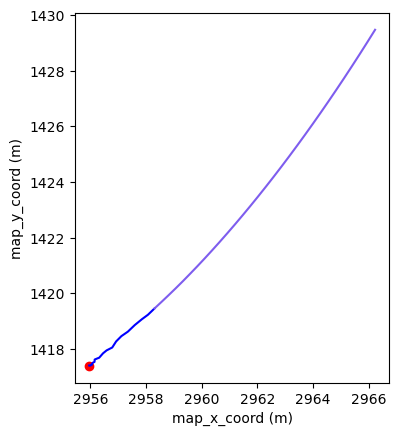

195/195{'minADE': 1.644107855129942, 'minFDE': 82.70729181993232}


In [ ]:
predict_traj = prediction_regression_2(df_demo)
print(predict_traj)
draw_trajectory(predict_traj)

print(afl.path_sequence[40])
df_demo_2 = afl.get_df(40)
predict_traj = prediction_regression_2(df_demo_2)
print(predict_traj)
draw_trajectory(predict_traj)

print(evaluation(afl, partial(prediction_regression_2), fast_run=True))

In [ ]:
def prediction_meanv(df: pd.DataFrame, past_points=20, pred_points=30, avg_points=1):
    #a simple prediction function that predict straight line with constant velocity
    
    df = df[df["OBJECT_TYPE"] == "AGENT"][["X", "Y"]]
    trajectory = df.iloc[:past_points].to_numpy()

    velocity_x_mps = []
    velocity_y_mps = []
    for i in range(1,avg_points+1,1):
        velocity_x_mps.append(trajectory[-i,0] - trajectory[-(1+i),0])
        velocity_y_mps.append(trajectory[-i,1] - trajectory[-(1+i),1])
    
    velocity_x_mps = np.mean(velocity_x_mps)
    velocity_y_mps = np.mean(velocity_y_mps)
    
    current_traj = trajectory[-1]
    results = np.zeros((len(trajectory)+pred_points,2))
    
    results[0:len(trajectory)] = trajectory
    
    for i in range(pred_points):
        results[len(trajectory)+i] = np.array([current_traj[0]+velocity_x_mps,current_traj[1]+velocity_y_mps])
        current_traj = results[len(trajectory)+i]
    return results

In [ ]:
# 测试集

# from lib.competition_util import generate_forecasting_h5

# afl_test = ArgoverseForecastingLoader("/mnt/d/dataset/Argoverse/test_obs/data")
# output_all = {}
# for i in range(len(afl_test)):
#     print('\r'+str(i + 1)+'/'+str(len(afl_test)),end="")
#     data = afl_test.get_df(i)
#     predict_traj = prediction_baseline_multi(data)
#     seq_id = int(os.path.basename(afl_test.path_sequence[i])[:-4])
#     output_all[seq_id] = predict_traj[:,20:,:]

In [ ]:
# output_path = 'competition_files/'
# generate_forecasting_h5(output_all, output_path) #this might take awhile